## Comparison

In [24]:
import numpy as np
import pandas as pd
from os import path, listdir
from sklearn.metrics import multilabel_confusion_matrix, classification_report, f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from typing import Dict
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable

In [26]:
class Evaluation:
    def __init__(self, model_name:str):
        base_path = "/home/jovyan/work/data/results"
        self.results: Dict[str, pd.DataFrame] = {}
        for folder in listdir(f"{base_path}/{model_name}"):
            for file in listdir(f"{base_path}/{model_name}/{folder}"):
                self.results[f"{folder}-{path.splitext(file)[0]}"] = pd.read_pickle(f"{base_path}/{model_name}/{folder}/{file}")
        self.model = model_name

    def get_all_tvp_results(self):
        return {key: value for key, value in self.results.items() if key.endswith("tvp")}

    
    def get_tvp_with_confidence(self, result_name: str):
        scores_df = self.results.get(result_name)
        tvp_df = Evaluation('navteca/nli-deberta-v3-large').results.get(f'{result_name}_tvp')

        # add corresponding confidence of predicted labels from scores df
        scores = []
        for index, row in tvp_df.iterrows():
            scores.append(scores_df.loc[index, row['y_pred']])

        tvp_df['confidence'] = scores

        # Sort by confidence
        return tvp_df.sort_values(by=['confidence'], ascending=False)

    def get_confusion_matrix(self, result_name: str):
        if not result_name.endswith("tvp"):
            raise ValueError("Confusion matrix is only available for test vs. prediction results.")
        y_test = self.results[result_name]['y_test']
        y_pred = self.results[result_name]['y_pred']
        return multilabel_confusion_matrix(y_test, y_pred)

    def get_classification_report(self, result_name: str):
        if not result_name.endswith("tvp"):
            raise ValueError("Classification report is only available for test vs. prediction results.")
        y_test = self.results[result_name]['y_test']
        y_pred = self.results[result_name]['y_pred']
        return classification_report(y_test, y_pred)

    def get_labels(self, result_name: str):
        if not result_name.endswith("tvp"):
            raise ValueError("Labels are only available for test vs. prediction results.")
        return self.results[result_name]['y_test'].unique()

    def get_weighted_kpi(self, measurement:Callable, custom_prompt = False):
        kpi = 0
        total = 0
        for key, value in self.results.items():
            if key.endswith("tvp"):
                if custom_prompt:
                    if key.startswith("custom"):
                        kpi += measurement(value['y_test'], value['y_pred']) / len(value['y_test'])
                        total += len(value['y_test'])
                else:
                    if not key.startswith("custom"):
                        kpi += measurement(value['y_test'], value['y_pred']) / len(value['y_test'])
                        total += len(value['y_test'])
        return kpi * total / 100

    def get_weighted_kpi_per_dataset(self, measurement:Callable, custom_prompt = False):
        dataset_vector = []
        kpi_vector = []
        observations_vector = []
        labels_vector = []
        for key, value in self.results.items():
            if key.endswith("tvp"):
                if custom_prompt:
                    if key.startswith("custom"):
                        kpi_vector.append(measurement(value['y_test'], value['y_pred']))
                        dataset_vector.append(key)
                        observations_vector.append(len(value['y_test']))
                        labels_vector.append(len(self.get_labels(key)))
                else:
                    if not key.startswith("custom"):
                        kpi_vector.append(measurement(value['y_test'], value['y_pred']))
                        dataset_vector.append(key)
                        observations_vector.append(len(value['y_test']))
                        labels_vector.append(len(self.get_labels(key)))
        return {"dataset": dataset_vector, "kpi": kpi_vector, "amt_observations": observations_vector, "amt_labels": labels_vector}

    def get_weighted_f1(self, custom_prompt = False):
        return self.get_weighted_kpi(lambda y_test, y_pred: f1_score(y_test, y_pred, average='weighted'), custom_prompt)

    def get_weighted_accuracy(self, custom_prompt = False):
            return self.get_weighted_kpi(lambda y_test, y_pred: balanced_accuracy_score(y_test, y_pred), custom_prompt)

    def get_accuracy(self, custom_prompt = False):
            return self.get_weighted_kpi(lambda y_test, y_pred: accuracy_score(y_test, y_pred), custom_prompt)

    def get_weighted_precision(self, custom_prompt = False):
        return self.get_weighted_kpi(lambda y_test, y_pred: precision_score(y_test, y_pred, average='weighted', zero_division=0), custom_prompt)

    def get_weighted_recall(self, custom_prompt = False):
        return self.get_weighted_kpi(lambda y_test, y_pred: recall_score(y_test, y_pred, average='weighted', zero_division=0), custom_prompt)

    def get_weighted_f1_per_dataset(self, custom_prompt = False):
        return self.get_weighted_kpi_per_dataset(lambda y_test, y_pred: f1_score(y_test, y_pred, average='weighted'), custom_prompt)

    def get_weighted_accuracy_per_dataset(self, custom_prompt = False):
        return self.get_weighted_kpi_per_dataset(lambda y_test, y_pred: balanced_accuracy_score(y_test, y_pred), custom_prompt)

    def get_accuracy_per_dataset(self, custom_prompt = False):
        return self.get_weighted_kpi_per_dataset(lambda y_test, y_pred: accuracy_score(y_test, y_pred), custom_prompt)

    def get_weighted_precision_per_dataset(self, custom_prompt = False):
        return self.get_weighted_kpi_per_dataset(lambda y_test, y_pred: precision_score(y_test, y_pred, average='weighted', zero_division=0), custom_prompt)

    def get_weighted_recall_per_dataset(self, custom_prompt = False):
        return self.get_weighted_kpi_per_dataset(lambda y_test, y_pred: recall_score(y_test, y_pred, average='weighted', zero_division=0), custom_prompt)

    def get_weighted_stats(self):
        return {
            "f1": self.get_weighted_f1(),
            "f1_custom": self.get_weighted_f1(custom_prompt = True),
            "accuracy": self.get_weighted_accuracy(),
            "accuracy_custom": self.get_weighted_accuracy(custom_prompt = True),
            "precision": self.get_weighted_precision(),
            "precision_custom": self.get_weighted_precision(custom_prompt = True),
            "recall": self.get_weighted_recall(),
            "recall_custom": self.get_weighted_recall(custom_prompt = True)
        }

    def print_confusion_matrix(self, axes, class_label, class_names, result_name:str, fontsize=14 ):
        if not result_name.endswith("tvp"):
            raise ValueError("Confusion Matrixes are only available for test vs. prediction results.")
        df_cm = pd.DataFrame(
            self.get_confusion_matrix(result_name), index=class_names, columns=class_names,
        )

        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        axes.set_ylabel('True label')
        axes.set_xlabel('Predicted label')
        axes.set_title("Category: " + class_label)
    


## Scores for default prompt

In [27]:
datasets = ["default_prompt-overview_wi_research_method_tvp", "default_prompt-overview_wi_theory_type_tvp", "default_prompt-overview_misq_theory_types_tvp", "default_prompt-ai_in_is_data_collection_techniques_tvp", "default_prompt-ai_in_is_types_tvp"]

bart_large = Evaluation("facebook/bart-large-mnli")
for key in bart_large.results.keys(): 
    if key.endswith("tvp"):
        print(key)
random = Evaluation("random")
gpt35turbo = Evaluation("gpt-3.5-turbo")
gpt4 = Evaluation("gpt-4")
gpt45full = Evaluation("gpt-4-0125-preview_fulltext")
deberta_v3_large = Evaluation("navteca/nli-deberta-v3-large")

df = pd.DataFrame.from_dict({
    "Random": random.get_weighted_stats(),
    "GPT-3.5-Turbo": gpt35turbo.get_weighted_stats(),
    "GPT-4": gpt4.get_weighted_stats(),
    "DeBERTa-v3-Large": deberta_v3_large.get_weighted_stats(),
})

dft = df.T

s = dft.style.highlight_max(axis=None,
                           props='bfseries: ;')

dft_no_custom = dft.drop(["f1_custom", "accuracy_custom", "precision_custom", "recall_custom"], axis=1)
dft_no_custom = dft_no_custom.round(3)
dft_no_custom = dft_no_custom.sort_values(by=["f1"], ascending=True)

print(dft_no_custom.to_csv())
dft_no_custom



custom_prompt-data_completeness_in_healthcare_tvp
custom_prompt-overview_wi_research_method_tvp
custom_prompt-ai_in_is_types_tvp
custom_prompt-overview_wi_theory_type_tvp
custom_prompt-machine_learning_in_business_tvp
custom_prompt-overview_misq_theory_types_tvp
custom_prompt-ai_in_is_data_collection_techniques_tvp
custom_prompt-search_engine_advertising_tvp
custom_prompt-overview_eswa_ml_approach_tvp
default_prompt-data_completeness_in_healthcare_tvp
default_prompt-overview_wi_research_method_tvp
default_prompt-ai_in_is_types_tvp
default_prompt-overview_wi_theory_type_tvp
default_prompt-machine_learning_in_business_tvp
default_prompt-overview_misq_theory_types_tvp
default_prompt-ai_in_is_data_collection_techniques_tvp
default_prompt-search_engine_advertising_tvp
default_prompt-overview_eswa_ml_approach_tvp
,f1,accuracy,precision,recall
Random,0.278,0.241,0.401,0.251
GPT-3.5-Turbo,0.723,0.724,0.824,0.745
GPT-4,0.739,0.686,0.845,0.74
DeBERTa-v3-Large,0.744,0.698,0.84,0.723



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,f1,accuracy,precision,recall
Random,0.278,0.241,0.401,0.251
GPT-3.5-Turbo,0.723,0.724,0.824,0.745
GPT-4,0.739,0.686,0.845,0.740
DeBERTa-v3-Large,0.744,0.698,0.840,0.723


In [38]:
gpt45full = Evaluation("gpt-4-0125-preview_fulltext")

pd.DataFrame.from_dict(gpt45full.get_weighted_f1_per_dataset())

,dataset,kpi,amt_observations,amt_labels
0,default_prompt-ai_in_is_data_collection_techni...,0.154294,78,12
1,default_prompt-ai_in_is_types_fulltext_tvp,0.504049,83,5


In [39]:
pd.DataFrame.from_dict(gpt45full.get_weighted_accuracy_per_dataset())

,dataset,kpi,amt_observations,amt_labels
0,default_prompt-ai_in_is_data_collection_techni...,0.126389,78,12
1,default_prompt-ai_in_is_types_fulltext_tvp,0.151724,83,5


In [43]:
pd.DataFrame.from_dict(gpt45full.get_weighted_recall_per_dataset())

,dataset,kpi,amt_observations,amt_labels
0,default_prompt-ai_in_is_data_collection_techni...,0.141026,78,12
1,default_prompt-ai_in_is_types_fulltext_tvp,0.530120,83,5


In [44]:
pd.DataFrame.from_dict(gpt45full.get_weighted_precision_per_dataset())

,dataset,kpi,amt_observations,amt_labels
0,default_prompt-ai_in_is_data_collection_techni...,0.212257,78,12
1,default_prompt-ai_in_is_types_fulltext_tvp,0.480422,83,5


## Per-Dataset-F1

In [33]:
df = pd.DataFrame.from_dict({
    "Random": random.get_weighted_f1_per_dataset().get("kpi"),
    "GPT-4": gpt4.get_weighted_f1_per_dataset().get("kpi"),
    "DBT v3 L": deberta_v3_large.get_weighted_f1_per_dataset().get("kpi"),
})

df = pd.concat([df, pd.DataFrame.from_dict({"dataset" : bart_large.get_weighted_f1_per_dataset().get("dataset")})], axis=1)
df = pd.concat([df, pd.DataFrame.from_dict({"observations" : bart_large.get_weighted_f1_per_dataset().get("amt_observations")})], axis=1)
# add amount of labels per dataset
df = pd.concat([df, pd.DataFrame.from_dict({"labels" : bart_large.get_weighted_f1_per_dataset().get("amt_labels")})], axis=1)

df = df[df['dataset'].isin(datasets)]

df["dataset"] = df['dataset'].apply(lambda x: x[15:])
df["dataset"] = df['dataset'].apply(lambda x: x[:-4])

df.insert(0, 'dataset', df.pop('dataset'))
df = df.round(3)
df = df.sort_values(by=["observations"], ascending=True)
#print(df.to_latex())
df

,dataset,Random,GPT-4,DBT v3 L,observations,labels
1,overview_wi_research_method,0.080,0.557,0.491,36,8
3,overview_wi_theory_type,0.344,0.658,0.661,36,3
5,overview_misq_theory_types,0.165,0.160,0.234,50,5
6,ai_in_is_data_collection_techniques,0.084,0.480,0.478,78,12
2,ai_in_is_types,0.178,0.707,0.749,83,5


## Balanced Acc

In [41]:
df = pd.DataFrame.from_dict({
    "Random": random.get_weighted_accuracy_per_dataset().get("kpi"),
    "GPT-4" : gpt4.get_weighted_accuracy_per_dataset().get("kpi"),
    "DBT v3 L": deberta_v3_large.get_weighted_accuracy_per_dataset().get("kpi"),
})

df = pd.concat([df, pd.DataFrame.from_dict({"dataset" : bart_large.get_weighted_accuracy_per_dataset().get("dataset")})], axis=1)
df = pd.concat([df, pd.DataFrame.from_dict({"observations" : bart_large.get_weighted_accuracy_per_dataset().get("amt_observations")})], axis=1)
# add amount of labels per dataset
df = pd.concat([df, pd.DataFrame.from_dict({"labels" : bart_large.get_weighted_accuracy_per_dataset().get("amt_labels")})], axis=1)

df = df[df['dataset'].isin(datasets)]

df["dataset"] = df['dataset'].apply(lambda x: x[15:])
df["dataset"] = df['dataset'].apply(lambda x: x[:-4])
df.insert(0, 'dataset', df.pop('dataset'))
df = df.round(3)
df = df.sort_values(by=["observations"], ascending=True)
#print(df.to_latex())
df
print(df.to_csv(index=False))

dataset,Random,GPT-4,DBT v3 L,observations,labels
overview_wi_research_method,0.111,0.358,0.448,36,8
overview_wi_theory_type,0.294,0.591,0.675,36,3
overview_misq_theory_types,0.152,0.212,0.164,50,5
ai_in_is_data_collection_techniques,0.067,0.363,0.313,78,12
ai_in_is_types,0.207,0.586,0.604,83,5



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


# Recall

In [22]:
df = pd.DataFrame.from_dict({
    "Random": random.get_weighted_recall_per_dataset().get("kpi"),
    "GPT-4" : gpt4.get_weighted_recall_per_dataset().get("kpi"),
    "DBT v3 L": deberta_v3_large.get_weighted_recall_per_dataset().get("kpi"),
})

df = pd.concat([df, pd.DataFrame.from_dict({"dataset" : bart_large.get_weighted_accuracy_per_dataset().get("dataset")})], axis=1)
df = pd.concat([df, pd.DataFrame.from_dict({"observations" : bart_large.get_weighted_accuracy_per_dataset().get("amt_observations")})], axis=1)
# add amount of labels per dataset
df = pd.concat([df, pd.DataFrame.from_dict({"labels" : bart_large.get_weighted_accuracy_per_dataset().get("amt_labels")})], axis=1)

df = df[df['dataset'].isin(datasets)]

df["dataset"] = df['dataset'].apply(lambda x: x[15:])
df["dataset"] = df['dataset'].apply(lambda x: x[:-4])
df.insert(0, 'dataset', df.pop('dataset'))
df = df.round(3)
df = df.sort_values(by=["observations"], ascending=True)
#print(df.to_latex())
print(df.to_csv(index=False))
df

dataset,Random,GPT-4,DBT v3 L,observations,labels
overview_wi_research_method,0.083,0.556,0.472,36,8
overview_wi_theory_type,0.306,0.639,0.639,36,3
overview_misq_theory_types,0.14,0.18,0.18,50,5
ai_in_is_data_collection_techniques,0.064,0.41,0.385,78,12
ai_in_is_types,0.157,0.711,0.771,83,5



,dataset,Random,GPT-4,DBT v3 L,observations,labels
1,overview_wi_research_method,0.083,0.556,0.472,36,8
3,overview_wi_theory_type,0.306,0.639,0.639,36,3
5,overview_misq_theory_types,0.140,0.180,0.180,50,5
6,ai_in_is_data_collection_techniques,0.064,0.410,0.385,78,12
2,ai_in_is_types,0.157,0.711,0.771,83,5


# Precision

In [23]:
df = pd.DataFrame.from_dict({
    "Random": random.get_weighted_precision_per_dataset().get("kpi"),
    "GPT-4" : gpt4.get_weighted_precision_per_dataset().get("kpi"),
    "DBT v3 L": deberta_v3_large.get_weighted_precision_per_dataset().get("kpi"),
})

df = pd.concat([df, pd.DataFrame.from_dict({"dataset" : bart_large.get_weighted_accuracy_per_dataset().get("dataset")})], axis=1)
df = pd.concat([df, pd.DataFrame.from_dict({"observations" : bart_large.get_weighted_accuracy_per_dataset().get("amt_observations")})], axis=1)
# add amount of labels per dataset
df = pd.concat([df, pd.DataFrame.from_dict({"labels" : bart_large.get_weighted_accuracy_per_dataset().get("amt_labels")})], axis=1)

df = df[df['dataset'].isin(datasets)]

df["dataset"] = df['dataset'].apply(lambda x: x[15:])
df["dataset"] = df['dataset'].apply(lambda x: x[:-4])
df.insert(0, 'dataset', df.pop('dataset'))
df = df.round(3)
df = df.sort_values(by=["observations"], ascending=True)
#print(df.to_latex())
print(df.to_csv(index=False))
df

dataset,Random,GPT-4,DBT v3 L,observations,labels
overview_wi_research_method,0.151,0.63,0.589,36,8
overview_wi_theory_type,0.427,0.762,0.8,36,3
overview_misq_theory_types,0.449,0.723,0.542,50,5
ai_in_is_data_collection_techniques,0.143,0.62,0.721,78,12
ai_in_is_types,0.38,0.719,0.732,83,5



,dataset,Random,GPT-4,DBT v3 L,observations,labels
1,overview_wi_research_method,0.151,0.630,0.589,36,8
3,overview_wi_theory_type,0.427,0.762,0.800,36,3
5,overview_misq_theory_types,0.449,0.723,0.542,50,5
6,ai_in_is_data_collection_techniques,0.143,0.620,0.721,78,12
2,ai_in_is_types,0.380,0.719,0.732,83,5


### Chart

<Axes: title={'center': 'F1 per Dataset'}, xlabel='Dataset', ylabel='F1'>

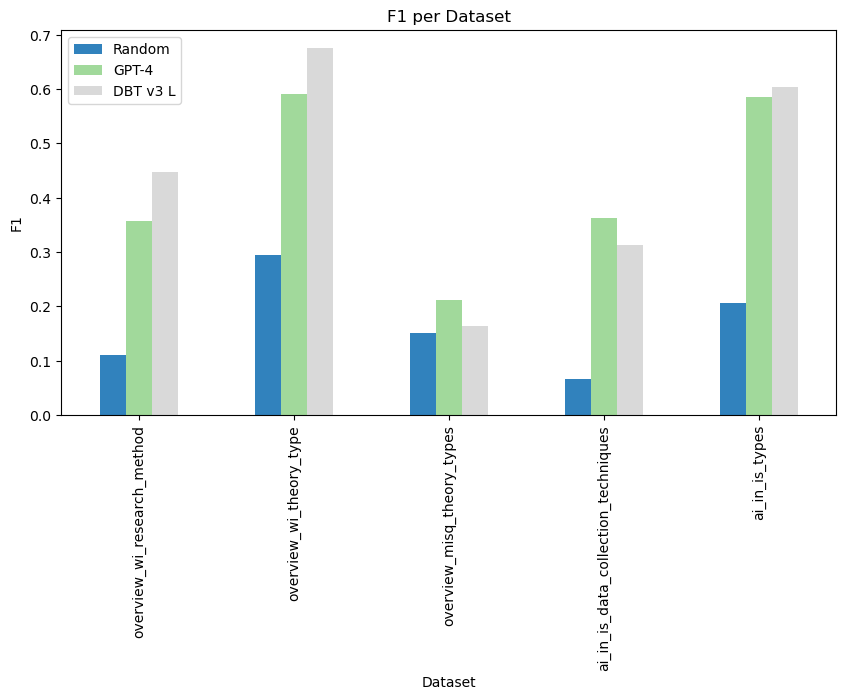

In [35]:
df.plot(x="dataset", y=["Random", "GPT-4", "DBT v3 L"], kind="bar", figsize=(10,5), title="F1 per Dataset", ylabel="F1", xlabel="Dataset", rot=90, colormap="tab20c", grid=False)

<Axes: title={'center': 'Unique Labels per Dataset'}, xlabel='Dataset', ylabel='Labels'>

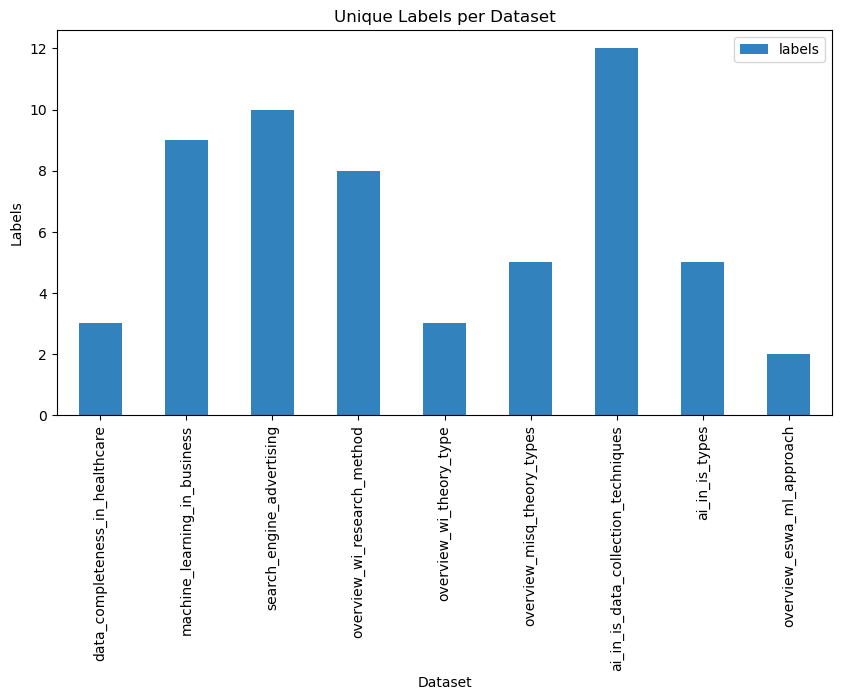

In [11]:

df.plot(x="dataset", y=["labels"], kind="bar", figsize=(10,5), title="Unique Labels per Dataset", ylabel="Labels", xlabel="Dataset", rot=90, colormap="tab20c", grid=False)

# Acc

In [42]:
df = pd.DataFrame.from_dict({
    "Random": random.get_accuracy_per_dataset().get("kpi"),
    "GPT-4" : gpt4.get_accuracy_per_dataset().get("kpi"),
    "DBT v3 L": deberta_v3_large.get_accuracy_per_dataset().get("kpi"),
})

df = pd.concat([df, pd.DataFrame.from_dict({"dataset" : bart_large.get_accuracy_per_dataset().get("dataset")})], axis=1)
df = pd.concat([df, pd.DataFrame.from_dict({"observations" : bart_large.get_accuracy_per_dataset().get("amt_observations")})], axis=1)
# add amount of labels per dataset
df = pd.concat([df, pd.DataFrame.from_dict({"labels" : bart_large.get_accuracy_per_dataset().get("amt_labels")})], axis=1)

df = df[df['dataset'].isin(datasets)]

df["dataset"] = df['dataset'].apply(lambda x: x[15:])
df["dataset"] = df['dataset'].apply(lambda x: x[:-4])
df.insert(0, 'dataset', df.pop('dataset'))
df = df.round(3)
df = df.sort_values(by=["observations"], ascending=True)
#print(df.to_latex())
print(df.to_csv(index=False))
df

dataset,Random,GPT-4,DBT v3 L,observations,labels
overview_wi_research_method,0.083,0.556,0.472,36,8
overview_wi_theory_type,0.306,0.639,0.639,36,3
overview_misq_theory_types,0.14,0.18,0.18,50,5
ai_in_is_data_collection_techniques,0.064,0.41,0.385,78,12
ai_in_is_types,0.157,0.711,0.771,83,5



,dataset,Random,GPT-4,DBT v3 L,observations,labels
1,overview_wi_research_method,0.083,0.556,0.472,36,8
3,overview_wi_theory_type,0.306,0.639,0.639,36,3
5,overview_misq_theory_types,0.140,0.180,0.180,50,5
6,ai_in_is_data_collection_techniques,0.064,0.410,0.385,78,12
2,ai_in_is_types,0.157,0.711,0.771,83,5


## Per-Dataset precision

In [8]:
df = pd.DataFrame.from_dict({
    "Random": random.get_weighted_precision_per_dataset(custom_prompt=False).get("kpi"),
    "DeBERTa-v3-Large": deberta_v3_large.get_weighted_precision_per_dataset(custom_prompt=False).get("kpi"),
})

df = pd.concat([df, pd.DataFrame.from_dict({"dataset" : bart_large.get_weighted_precision_per_dataset(custom_prompt=False).get("dataset")})], axis=1)
pd.concat([df, pd.DataFrame.from_dict({"observations" : bart_large.get_weighted_precision_per_dataset().get("amt_observations")})], axis=1)

,Random,DeBERTa-v3-Large,dataset,observations
0,0.517460,0.760000,default_prompt-data_completeness_in_healthcare...,15
1,0.558333,0.588853,default_prompt-overview_wi_research_method_tvp,36
2,0.569411,0.732003,default_prompt-ai_in_is_types_tvp,83
3,0.390404,0.800245,default_prompt-overview_wi_theory_type_tvp,36
4,0.008000,0.899048,default_prompt-machine_learning_in_business_tvp,25
5,0.454000,0.542086,default_prompt-overview_misq_theory_types_tvp,50
6,0.099817,0.721154,default_prompt-ai_in_is_data_collection_techni...,78
7,0.030000,0.510000,default_prompt-search_engine_advertising_tvp,25
8,0.678966,0.718060,default_prompt-overview_eswa_ml_approach_tvp,117


# Best and worst samples per dataset

In [48]:
evaluation = Evaluation('navteca/nli-deberta-v3-large')
df = evaluation.get_tvp_with_confidence('default_prompt-data_completeness_in_healthcare').head(10)
df

,abstract,y_test,y_pred,confidence
15,Background\nEvaluating the features and perfor...,evaluation,evaluation,0.984484
19,Background: With the introduction and implemen...,evaluation,evaluation,0.969446
5,Objectives: The first objective of this study ...,evaluation,evaluation,0.893574
18,Background: Vaccination registries have undoub...,evaluation,evaluation,0.746571
14,Background\nAudit Trails (AT) are fundamental ...,evaluation,evaluation,0.735701
16,Background: Evidence informed decision making ...,determinants,evaluation,0.664887
13,Background: Survival or outcome information is...,evaluation,evaluation,0.619575
10,Purpose: The purpose of this study was to eval...,evaluation,evaluation,0.607565
23,We demonstrate the importance of explicit defi...,evaluation,determinants,0.538300
20,This is the first paper of a series of two reg...,design and development,design and development,0.516969


In [49]:
df[df['y_test'] == df['y_pred']].head(1)

,abstract,y_test,y_pred,confidence
15,Background\nEvaluating the features and perfor...,evaluation,evaluation,0.984484


In [50]:
df[df['y_test'] != df['y_pred']].head(1)

,abstract,y_test,y_pred,confidence
16,Background: Evidence informed decision making ...,determinants,evaluation,0.664887


In [40]:
Evaluation('navteca/nli-deberta-v3-large').get_tvp_with_confidence('default_prompt-overview_wi_research_method').head(5)


,abstract,y_test,y_pred,confidence
19,Innovative Service Behavior (ISB) and its infl...,Framework,Laboratory experiment,0.993622
9,This study reports the results of a laboratory...,Laboratory experiment,Laboratory experiment,0.988937
21,The improved performance of technological capa...,Literature analysis,Literature analysis,0.894782
22,Sales talks between customers and sales person...,Laboratory experiment,Laboratory experiment,0.888299
25,Intelligent Voice Assistants (IVA) are voice-b...,Framework,Literature analysis,0.782754


In [21]:
Evaluation('navteca/nli-deberta-v3-large').get_tvp_with_confidence('default_prompt-ai_in_is_types').tail(10)


,abstract,y_test,y_pred,confidence
20,Intelligent software agents have been used in ...,machine learning,machine learning,0.422527
62,Researchers increasingly acknowledge that algo...,machine vision,machine learning,0.422387
79,A significant recent technological development...,expert systems,expert systems,0.420405
16,We study how artificial intelligence (AI) can ...,machine learning,machine learning,0.401492
63,We employ a conversational genre of performati...,natural language processing,machine learning,0.401383
74,The aim of the research described in this pape...,expert systems,expert systems,0.400966
3,The goal of a review article is to present the...,machine learning,machine learning,0.392351
67,Voice-based AI systems are gradually deployed ...,natural language processing,natural language processing,0.377519
21,Computers can use vast amounts of data to make...,machine learning,machine learning,0.370392
61,Technological developments in emerging AI tech...,machine vision,machine learning,0.314499


In [20]:
Evaluation('navteca/nli-deberta-v3-large').get_tvp_with_confidence('default_prompt-overview_wi_theory_type').tail(25)


,abstract,y_test,y_pred,confidence
18,Conversational agents (CA) interact in natural...,Design and Action,Design and Action,0.614024
32,Online product recommendation agents are becom...,Explanation,Explanation,0.613856
12,Gamification aims at improving people's motiva...,Design and Action,Analysis,0.602543
34,This research proposes that technological arti...,Explanation,Explanation,0.594145
22,Sales talks between customers and sales person...,Design and Action,Design and Action,0.569183
27,Based on the contradictory phenomenon of rapid...,Explanation,Analysis,0.534328
8,"Every day, people make decisions about whether...",Explanation,Explanation,0.521115
11,The 40-year-old Uncanny Valley theory is influ...,Explanation,Design and Action,0.505857
0,When cognitive computing enabled smart compute...,Explanation,Explanation,0.492578
17,A key challenge in designing conversational us...,Design and Action,Design and Action,0.484350


In [36]:
Evaluation('navteca/nli-deberta-v3-large').get_tvp_with_confidence('default_prompt-machine_learning_in_business').head(25)


,abstract,y_test,y_pred,confidence
17,With the rapid proliferation of images on e-co...,recommendation,recommendation,0.986283
0,The ubiquity of Web2.0 makes the Web an invalu...,review or feedback,review or feedback,0.977327
20,We propose a new online-to-offline (O2O) servi...,recommendation,recommendation,0.971793
7,This study explores online customer search beh...,conversion prediction,conversion prediction,0.970820
13,Product reviews and ratings are major quality ...,review or feedback,review or feedback,0.968775
5,Purpose Accurate prediction of order demand ac...,order prediction,order prediction,0.942266
6,Many leading e-commerce retailers adopt a cons...,pricing decisions,pricing decisions,0.938396
18,Recommender systems are a critical component o...,recommendation,recommendation,0.937183
2,"In today's transparent markets, e-commerce pro...",pricing decisions,pricing decisions,0.890418
9,There are three defects for providing human-la...,customer service,customer service,0.870555


In [19]:
Evaluation('navteca/nli-deberta-v3-large').get_tvp_with_confidence('default_prompt-overview_misq_theory_types').tail(27)


,abstract,y_test,y_pred,confidence
12,Information technology (IT) acceptance researc...,Explanation and Prediction,Explanation and Prediction,0.345980
14,Information technology (IT) innovation can be ...,Explanation and Prediction,Analysis,0.344660
28,We consider how the government should set the ...,Design,Analysis,0.343995
5,A concept of the user is fundamental to much o...,Explanation,Analysis,0.342322
6,Agility is vital to the innovation and competi...,Explanation and Prediction,Design,0.324797
29,Payoffs from information technology (IT) conti...,Explanation and Prediction,Analysis,0.317759
17,While traditional information systems research...,Analysis,Design,0.314925
7,Information technology can facilitate the diss...,Explanation and Prediction,Explanation,0.309460
11,Managers in modern organizations are confronte...,Explanation and Prediction,Design,0.307206
33,Generalizability is a major concern to those w...,Analysis,Explanation and Prediction,0.304700


In [31]:
Evaluation('navteca/nli-deberta-v3-large').get_tvp_with_confidence('default_prompt-ai_in_is_data_collection_techniques').head(10)


,abstract,y_test,y_pred,confidence
72,The improved performance of technological capa...,literature analysis,literature analysis,0.984988
79,Advances in the area of AI systems lead to the...,literature analysis,literature analysis,0.983660
81,Artificial intelligence and blockchain are amo...,literature analysis,literature analysis,0.982059
21,This study uses data mining techniques to exam...,data mining,data mining,0.977617
70,Machine learning is a useful technology for de...,literature analysis,literature analysis,0.976596
74,Artificial intelligence (AI) will transform bu...,literature analysis,literature analysis,0.934063
84,"In todays race for competitive advantages, mo...",workshop,literature analysis,0.925606
2,Bitcoin is a cryptocurrency whose transactions...,data mining,sample analysis,0.914545
43,This paper1 establishes the importance of situ...,observation,literature analysis,0.906926
30,Empowered by machine learning and artificial i...,experiment,sample analysis,0.871635


In [26]:
Evaluation('navteca/nli-deberta-v3-large').get_tvp_with_confidence('default_prompt-search_engine_advertising')


,abstract,y_test,y_pred,confidence
12,Click fraud is a growing concern for pay-per-c...,click fraud issues,click fraud issues,0.992056
1,This paper shows that the quality scores in sp...,auction mechanism design,bidding strategy optimization,0.991234
21,Recent years have witnessed the increased appl...,reviews on search engine advertising,real outcomes of search engine advertising,0.989912
0,"In this paper, we first describe a framework t...",auction mechanism design,auction mechanism design,0.985701
9,This paper investigates the composition of sea...,search engine result page analysis,search engine result page analysis,0.976759
19,"Every day people search the Internet, seeking ...",real outcomes of search engine advertising,web searchers' behaviour and practice,0.975635
14,Search engines stand as the first entry point ...,web searchers' behaviour and practice,web searchers' behaviour and practice,0.926384
13,"This study develops a theoretical model, based...",click fraud issues,advertisers' behaviour and practice,0.907518
17,The objective of this study is to examine adve...,advertisers' behaviour and practice,advertisers' behaviour and practice,0.885574
7,Introduction. The study of keyword suggestion ...,keyword selection,keyword selection,0.845013


In [30]:
Evaluation('navteca/nli-deberta-v3-large').get_tvp_with_confidence('default_prompt-overview_eswa_ml_approach').head(15)


,abstract,y_test,y_pred,confidence
83,We address the problem of recommending suitabl...,supervised learning,supervised learning,0.999952
18,The Linked Data initiative promotes the public...,supervised learning,supervised learning,0.999914
33,Different efforts have been done to address th...,supervised learning,supervised learning,0.999854
3,Under the different searches performed to anal...,supervised learning,supervised learning,0.999849
84,"In recent years, a considerable amount of atte...",supervised learning,supervised learning,0.999817
20,This paper describes an agent-based approach f...,supervised learning,supervised learning,0.999784
21,This paper describes a Recommender System that...,supervised learning,supervised learning,0.999715
96,We propose a method to recommend books through...,supervised learning,supervised learning,0.999610
27,This paper presents a content-based recommende...,supervised learning,supervised learning,0.999421
26,This paper presents content-based recommender ...,supervised learning,supervised learning,0.998852
